     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 14.9 MB/s eta 0:00:0000:0100:01


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras.models import Model


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
tf.random.set_seed(42)


In [2]:
def define_convTransformer(segment_size=256, sequence_length=5, nfeatures=8, nclasses=3):

    input_shape = (segment_size * sequence_length, nfeatures)

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)

    for _ in range(7):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(2)(x)

    # Transformer layers
    query_value_attention_seq = layers.MultiHeadAttention(num_heads=2, key_dim=2)(x, x)

    # Adding the self attention to the original sequence
    x = layers.Add()([x, query_value_attention_seq])

    # Layer Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Position-wise Feed-Forward Part
    x = layers.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    x = layers.Conv1D(filters=64, kernel_size=1, activation='relu')(x)

    # Adding the position-wise feedforward to the sequence
    x = layers.Add()([x, query_value_attention_seq])

    # Layer Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Removed Global Average Pooling to keep the time dimension

    # Dense layers for final classification - now it gives a prediction for each time step
    x = layers.TimeDistributed(layers.Dense(sequence_length, activation='relu'))(x)
    outputs = layers.TimeDistributed(layers.Dense(nclasses, activation='softmax'))(x)

    # Creating the model
    model = Model(inputs=inputs, outputs=outputs)

    return model



model2 = define_convTransformer()

2023-11-20 11:20:27.014286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-20 11:20:27.135933: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [133]:
# x_train_convT = np.load('../data/x_train.npy')
# y_train_convT = np.load('../data/y_train.npy')

x_train_convT = np.load('../data/x_train_75.npy')
y_train_convT = np.load('../data/y_train_75.npy')

In [121]:
np.isnan(x_train_convT).sum() / x_train_convT.size

0.0

In [122]:
x_train_convT.shape, y_train_convT.shape

((895, 640, 8), (895, 10, 3))

In [134]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
fit2 = model2.fit(
    x=x_train_convT,
    y=y_train_convT,
    batch_size=32,
    epochs=50,
    validation_split=0.2
)

Epoch 1/50
12/12 [==============================] - 2s 49ms/step - loss: 0.5814 - accuracy: 0.8218 - val_loss: 0.2257 - val_accuracy: 0.9453
Epoch 2/50
12/12 [==============================] - 0s 27ms/step - loss: 0.3426 - accuracy: 0.9167 - val_loss: 0.1825 - val_accuracy: 0.9453
Epoch 3/50
12/12 [==============================] - 0s 27ms/step - loss: 0.2580 - accuracy: 0.9220 - val_loss: 0.1517 - val_accuracy: 0.9453
Epoch 4/50
12/12 [==============================] - 0s 26ms/step - loss: 0.2025 - accuracy: 0.9310 - val_loss: 0.1443 - val_accuracy: 0.9474
Epoch 5/50
12/12 [==============================] - 0s 27ms/step - loss: 0.1623 - accuracy: 0.9443 - val_loss: 0.1240 - val_accuracy: 0.9516
Epoch 6/50
12/12 [==============================] - 0s 29ms/step - loss: 0.1621 - accuracy: 0.9485 - val_loss: 0.1448 - val_accuracy: 0.9516
Epoch 7/50
12/12 [==============================] - 0s 27ms/step - loss: 0.1407 - accuracy: 0.9554 - val_loss: 0.0982 - val_accuracy: 0.9726
Epoch 8/50
12

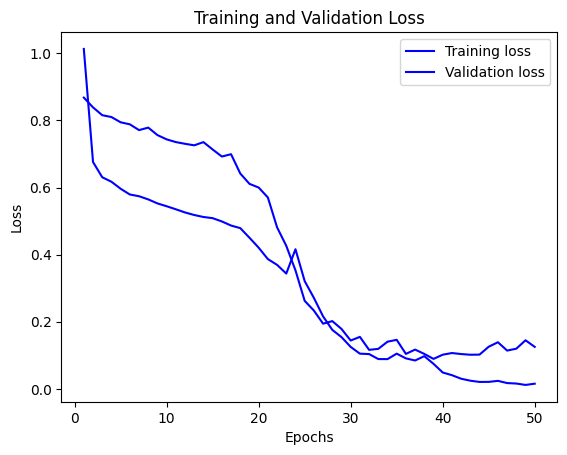

In [11]:
import matplotlib.pyplot as plt

history = fit2.history

train_loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.plot(epochs, train_loss, 'b', label='Training loss')  # 'bo' gives dot plot
plt.plot(epochs, val_loss, 'b', label='Validation loss')   # 'b' gives line plot
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

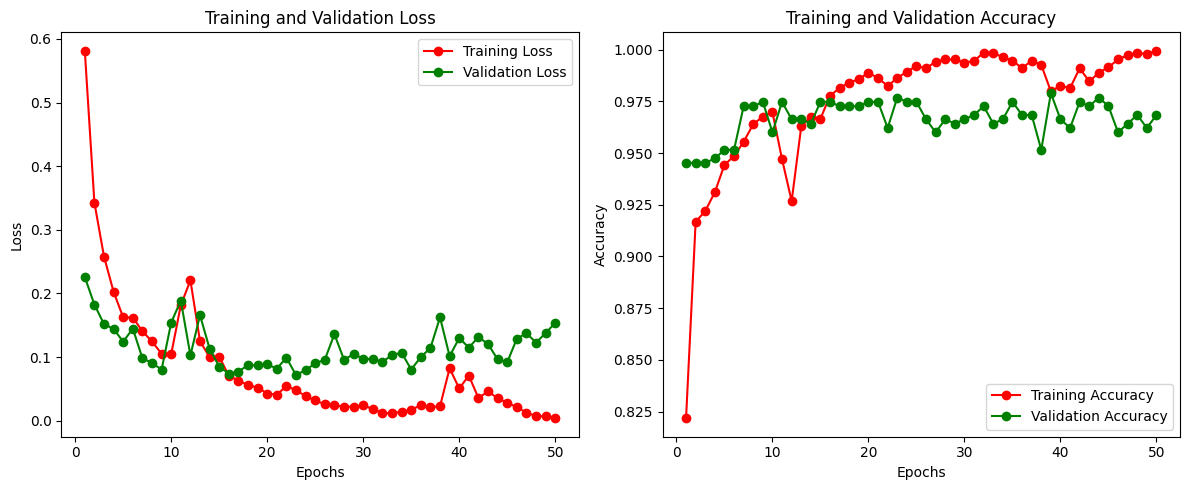

In [10]:
import matplotlib.pyplot as plt

history = fit2.history

# Assuming 'history' is your history object returned by the 'fit' method
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']  # Or 'acc' based on your TensorFlow version
val_acc = history['val_accuracy']  # Or 'val_acc' based on your TensorFlow version
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 5))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss', marker='o')  # Red color for training loss
plt.plot(epochs, val_loss, 'g', label='Validation Loss', marker='o')  # Green color for validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy', marker='o')  # Red color for training accuracy
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy', marker='o')  # Green color for validation accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
predictions = model2.predict(x_train_convT)
predicted_labels = np.argmax(predictions, axis = -1).flatten()

predicted_labels.shape, predicted_labels

15/15 [==============================] - 0s 8ms/step


((2360,), array([0, 0, 0, ..., 0, 0, 0]))

(array([2.36228814, 0.        , 0.        , 0.        , 0.        ,
        2.33050847, 0.        , 0.        , 0.        , 0.30720339]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

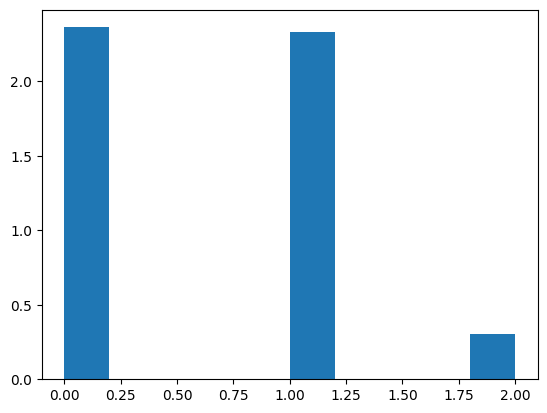

In [67]:
predicted_labels.shape

plt.hist(predicted_labels.flatten(), density=True)

In [47]:
import plotly.graph_objects as go
from collections import Counter

data = predicted_labels.flatten()

fig = go.Figure(data=[
    go.Histogram(x=data, histnorm='probability density')
])

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Text(0.5, 1.0, 'holi')

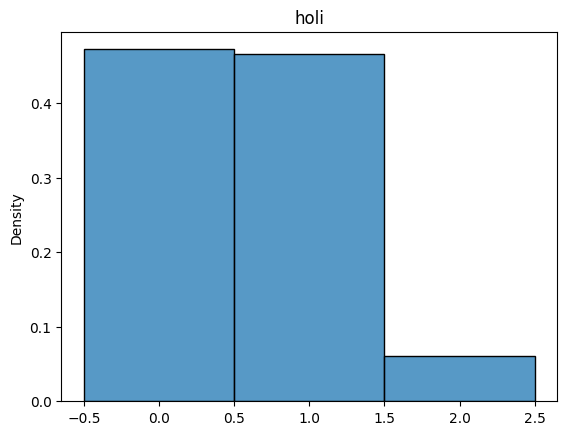

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt


data = predicted_labels.flatten()


sns.histplot(data, bins=[0, 1, 2, 3], stat='density', discrete=True)



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot using matplotlib
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))  # Replace `classes` with your list of classes
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the plot
thresh = cm.max() / 2.  # for text color
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# If you want a nicer visualization, use seaborn
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.show()

In [143]:
# def define_convTransformer(segment_size=256, sequence_length=5, nfeatures=8, nclasses=3):

def define_convTransformer(segment_size, sequence_length, nfeatures, nclasses):
    input_shape = (segment_size * sequence_length, nfeatures)

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)

    # for _ in range(7):
    for _ in range(5):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(2)(x)

    # Transformer layers
    query_value_attention_seq = layers.MultiHeadAttention(num_heads=2, key_dim=2)(x, x) # this is the W matrix that computes the query with the X. #if key_dim is 2, you get a 2 dim vector for each `word` # same thing for the matrix that computes the Keys, the matrix that computes the keys and the querys has to have the same dim. 

    # Adding the self attention to the original sequence
    x = layers.Add()([x, query_value_attention_seq])

    # Layer Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Position-wise Feed-Forward Part
    x = layers.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    x = layers.Conv1D(filters=64, kernel_size=1, activation='relu')(x)

    # Adding the position-wise feedforward to the sequence
    x = layers.Add()([x, query_value_attention_seq])

    # Layer Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Removed Global Average Pooling to keep the time dimension
    # x = layers.Conv1D(filters=8, kernel_size=1, activation='relu')(x) # por que esta esta aca? estaba descomentada antes

    # Dense layers for final classification - now it gives a prediction for each time step
    x = layers.TimeDistributed(layers.Dense(sequence_length, activation='relu'))(x)
    
    outputs = layers.TimeDistributed(layers.Dense(nclasses, activation='softmax'))(x)

    # Creating the model
    model = Model(inputs=inputs, outputs=outputs)

    return model



model3 = define_convTransformer(segment_size=64, sequence_length=10, nfeatures=8, nclasses=3)
#check spatial positioning encoding. It's in attention is all you need paper. 



In [144]:
model3.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 640, 8)]             0         []                            
                                                                                                  
 conv1d_287 (Conv1D)         (None, 640, 64)              1600      ['input_30[0][0]']            
                                                                                                  
 max_pooling1d_215 (MaxPool  (None, 320, 64)              0         ['conv1d_287[0][0]']          
 ing1D)                                                                                           
                                                                                                  
 conv1d_288 (Conv1D)         (None, 320, 64)              12352     ['max_pooling1d_215[0][

In [20]:
y_train_convT

array([[[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       ...,

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]])

In [142]:
x_train.shape, y_train.shape

((736, 640, 8), (736, 10, 3))

In [84]:
https://www.tensorflow.org/api_docs/python/tf/keras/Model



  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2959 sha256=e364dd4c79174709d309db647518d3c7f3201f02974f0547199e72b8839fb32c
  Stored in directory: /home/franfram/.cache/pip/wheels/52/cc/47/500a56407c060a5d18bda9aa3ec2daf4721b8448ee4b268840
Successfully built sklearn


In [135]:
from sklearn.model_selection import train_test_split
#while val split is not balanced repeat this
x_train, x_val, y_train, y_val = train_test_split(x_train_convT, y_train_convT, test_size=0.2, shuffle=True)

In [136]:
y_train.shape, y_val.shape

((736, 10, 3), (185, 10, 3))

In [137]:
from sklearn.utils import class_weight
import numpy as np

# Flatten the timestep and one-hot dimensions of your labels
# This will give you a 2D array of shape (472 * 5, 3), treating each timestep as a sample
y_train_flat = y_train.reshape(-1, y_train.shape[-1])

# Convert one-hot encoded labels to integers
y_train_integers = np.argmax(y_train_flat, axis=1)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers)

# Convert class weights to a dictionary to pass it to Keras
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.724766125061546, 1: 0.68663121559847, 2: 6.102819237147595}

(array([2.29959239, 0.        , 0.        , 0.        , 0.        ,
        2.42730978, 0.        , 0.        , 0.        , 0.27309783]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

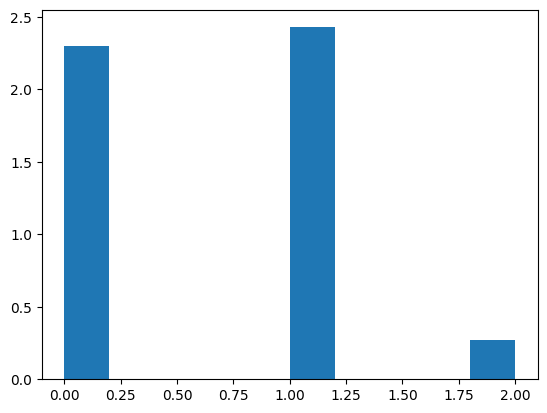

In [139]:
import matplotlib.pyplot as plt
plt.hist(y_train_integers, density=True)



In [49]:
# class_weights_dict[2] = 4
class_weights_dict

{0: 0.7059925093632958, 1: 0.7067866516685414, 2: 5.927672955974843}

In [141]:
x_train.shape, y_train.shape

((736, 640, 8), (736, 10, 3))

In [145]:


model3 = define_convTransformer(segment_size=64, sequence_length=10, nfeatures=8, nclasses=3)


model3.summary()

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



# # fit3 = model3.fit(
# #     x=x_train_convT,
# #     y=y_train_convT,
# #     batch_size=32,
# #     epochs=50,
# #     validation_split=0.2,
# #     shuffle=True,
# #     class_weight=class_weights_dict
# # )



fit5 = model3.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=70,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict
)




Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 640, 8)]             0         []                            
                                                                                                  
 conv1d_295 (Conv1D)         (None, 640, 64)              1600      ['input_31[0][0]']            
                                                                                                  
 max_pooling1d_221 (MaxPool  (None, 320, 64)              0         ['conv1d_295[0][0]']          
 ing1D)                                                                                           
                                                                                                  
 conv1d_296 (Conv1D)         (None, 320, 64)              12352     ['max_pooling1d_221[0][

In [146]:
plot_metrics(fit5)

In [97]:
x_train.shape, y_train.shape

((759, 640, 8), (759, 10, 3))

6/6 [==============================] - 0s 8ms/step


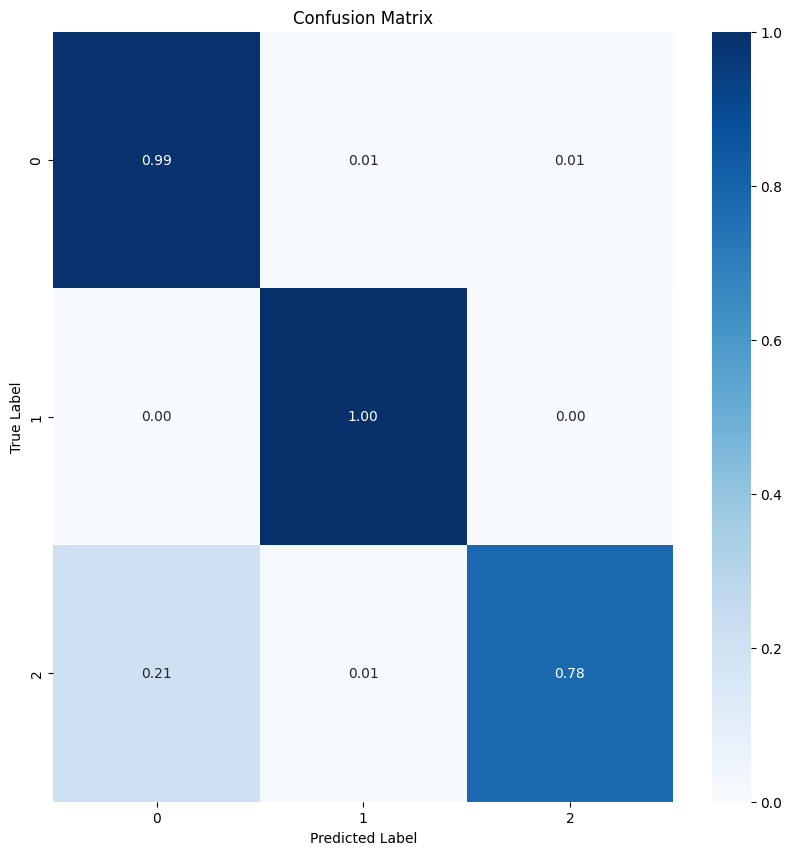

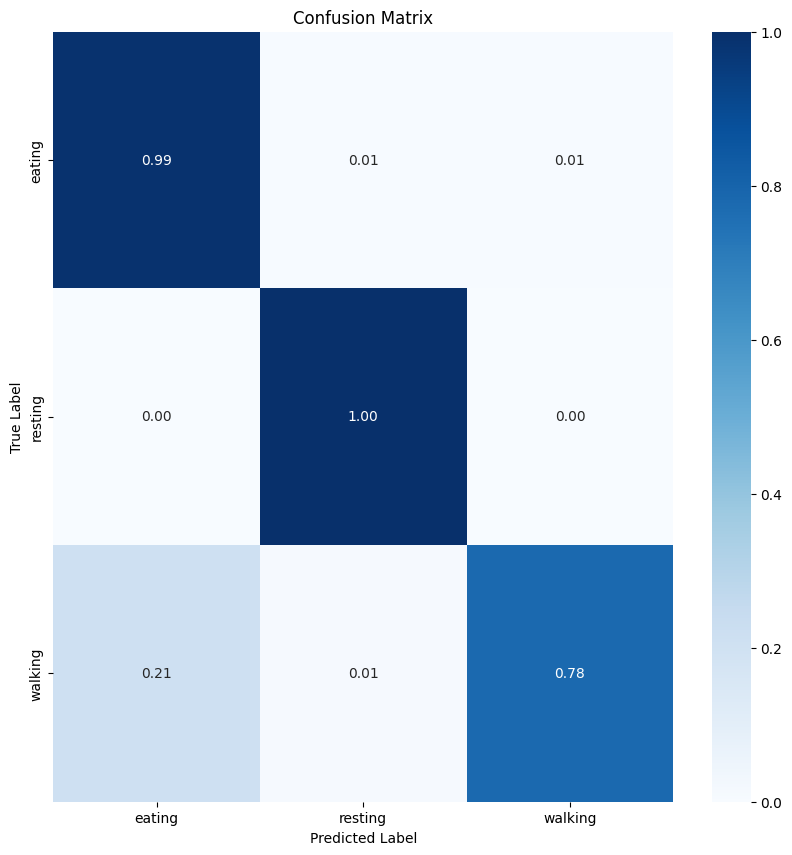

In [147]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on the test data
y_pred = model3.predict(x_val)

# Convert predictions from probability to class labels
y_pred_classes = np.argmax(y_pred, axis=-1)  # Assuming softmax output
y_true_classes = np.argmax(y_val, axis=-1)  # Convert true labels

# Reshape the predictions and true values to a 2D format
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
# If you want, you can also normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


# Define your label names corresponding to the integers
label_names = ['eating', 'resting', 'walking']  # Replace with your actual label names

# Create the confusion matrix plot
plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names)  # Set custom labels
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data



In [30]:
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1280, 8)]            0         []                            
                                                                                                  
 conv1d_40 (Conv1D)          (None, 1280, 64)             1600      ['input_5[0][0]']             
                                                                                                  
 max_pooling1d_32 (MaxPooli  (None, 640, 64)              0         ['conv1d_40[0][0]']           
 ng1D)                                                                                            
                                                                                                  
 conv1d_41 (Conv1D)          (None, 640, 64)              12352     ['max_pooling1d_32[0][0]

In [24]:
val_acc[10]

0.9494736790657043

In [53]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots



def plot_metrics(fit):

    history = fit.history
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']  # Or 'acc' based on your TensorFlow version
    val_acc = history['val_accuracy']  # Or 'val_acc' based on your TensorFlow version
    epochs = list(range(1, len(train_loss) + 1))

    # Create subplots: one row, two columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Training and Validation Loss', 'Training and Validation Accuracy'))

    # Define hover template
    hovertemplate = 'Epoch: %{x}<br>Value: %{y:.4f}<extra></extra>'

    # First subplot for loss
    fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Training Loss', 
                            marker_color='red', hovertemplate=hovertemplate), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss', 
                            marker_color='green', hovertemplate=hovertemplate), row=1, col=1)

    # Second subplot for accuracy
    fig.add_trace(go.Scatter(x=epochs, y=train_acc, mode='lines+markers', name='Training Accuracy', 
                            marker_color='red', hovertemplate=hovertemplate), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy', 
                            marker_color='green', hovertemplate=hovertemplate), row=1, col=2)

    # Update xaxis properties
    # fig.update_xaxes(title_text='Epochs', tickmode='linear', row=1, col=1)
    # fig.update_xaxes(title_text='Epochs', tickmode='linear', row=1, col=2)

    # Update yaxis properties
    fig.update_yaxes(title_text='Loss', row=1, col=1)
    fig.update_yaxes(title_text='Accuracy', row=1, col=2)

    # Update layout and show plot
    fig.update_layout(title_text='Training and Validation Metrics', showlegend=True)
    fig.show()
    
plot_metrics(fit4)

3/3 [==============================] - 0s 20ms/step


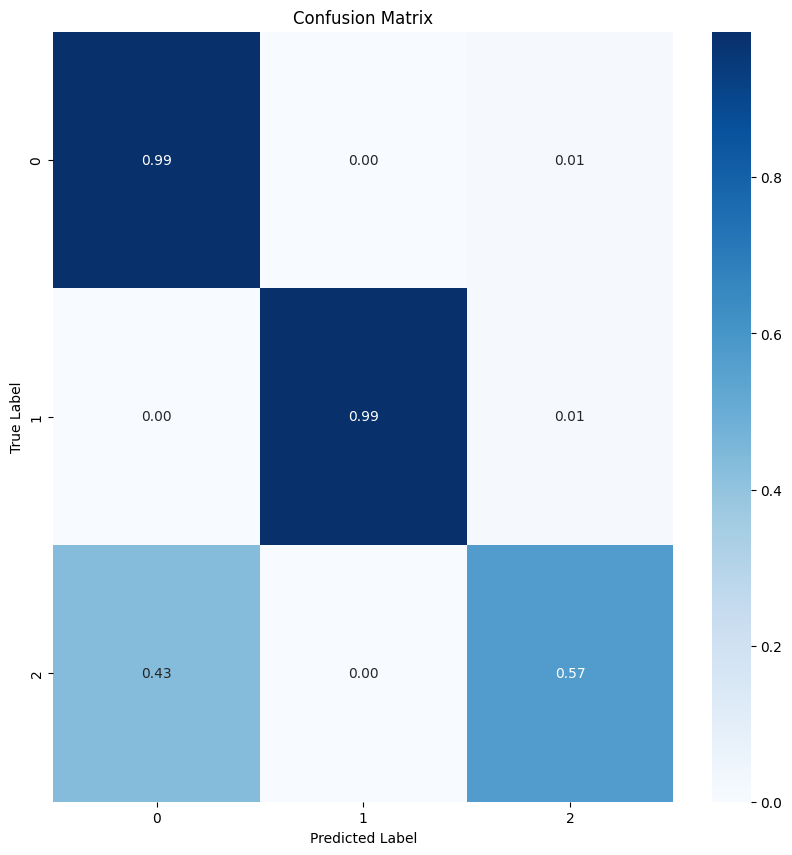

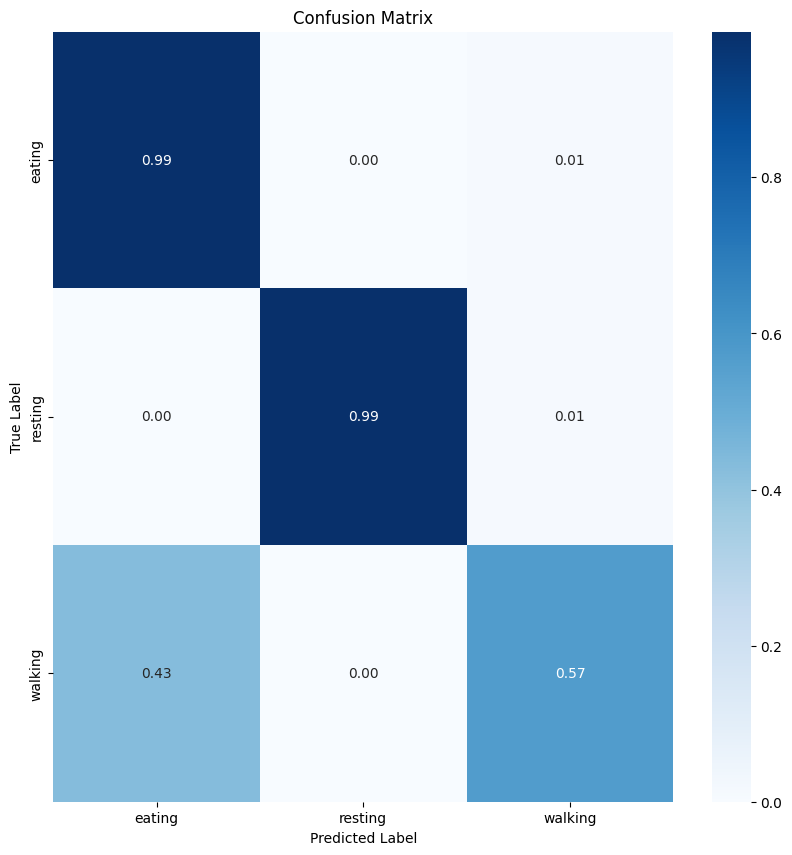

In [74]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on the test data
y_pred = model3.predict(x_val)

# Convert predictions from probability to class labels
y_pred_classes = np.argmax(y_pred, axis=-1)  # Assuming softmax output
y_true_classes = np.argmax(y_val, axis=-1)  # Convert true labels

# Reshape the predictions and true values to a 2D format
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
# If you want, you can also normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


# Define your label names corresponding to the integers
label_names = ['eating', 'resting', 'walking']  # Replace with your actual label names

# Create the confusion matrix plot
plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names)  # Set custom labels
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [65]:
y_pred.shape

(95, 5, 3)

In [58]:
import json
def save_model_run(fit, name: str):

    # Convert the history's values to lists
    history_dict = {key: value for key, value in fit.history.items()}

    # Save as JSON
    with open(f'history_{name}.json', 'w') as f:
        json.dump(history_dict, f)

In [59]:
save_model_run(fit4, 'conv_transformer')

In [61]:
with open('history_conv_transformer_goodfit.json', 'r') as f:
    test = json.load(f)

In [62]:
test

{'loss': [0.9245688319206238,
  0.616095244884491,
  0.5632547736167908,
  0.5294764041900635,
  0.5023446679115295,
  0.4918553829193115,
  0.4984879493713379,
  0.4800112843513489,
  0.47057607769966125,
  0.4606386125087738,
  0.42826658487319946,
  0.4029100239276886,
  0.3403598368167877,
  0.34101924300193787,
  0.36220601201057434,
  0.31177031993865967,
  0.2635596990585327,
  0.2682682275772095,
  0.24989408254623413,
  0.30376526713371277,
  0.22269994020462036,
  0.24579297006130219,
  0.1600131243467331,
  0.13007521629333496,
  0.12421374768018723,
  0.11763425171375275,
  0.1134609580039978,
  0.10386423766613007,
  0.09829547256231308,
  0.09715159982442856,
  0.0796278566122055,
  0.10591934621334076,
  0.12156279385089874,
  0.07267918437719345,
  0.0553363636136055,
  0.037745483219623566,
  0.03833814337849617,
  0.04909377917647362,
  0.04523644223809242,
  0.033265575766563416,
  0.03407835587859154,
  0.05133287236094475,
  0.19203634560108185,
  0.227871760725975

In [44]:
print(f"Validation accuracy before model starts overfitting: {round(val_acc[17], 3)}%")

Validation accuracy before model starts overfitting: 0.973%


In [ ]:
https://stackoverflow.com/questions/60475162/why-is-my-neural-network-validation-accuracy-higher-than-my-training-accuracy-an


CHECK

In [44]:
def define_convTransformer(segment_size=256, sequence_length=5, nfeatures=8, nclasses=3):

    #input_shape = (5120, 8)
    input_shape = (segment_size * sequence_length, nfeatures)

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)

    for _ in range(7):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(2)(x)

    # Transformer layers
    # query_value_attention_seq = layers.MultiHeadAttention(num_heads=2, key_dim=2)(x, x)

    # # Adding the self attention to the original sequence
    # x = layers.Add()([x, query_value_attention_seq])

    # # Layer Normalization
    # x = layers.LayerNormalization(epsilon=1e-6)(x)

    # # Position-wise Feed-Forward Part
    # x = layers.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    # x = layers.Conv1D(filters=64, kernel_size=1, activation='relu')(x)

    # # Adding the position-wise feedforward to the sequence
    # x = layers.Add()([x, query_value_attention_seq])

    # Layer Normalization
    # x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Removed Global Average Pooling to keep the time dimension

    # Dense layers for final classification - now it gives a prediction for each time step
    x = layers.TimeDistributed(layers.Dense(sequence_length, activation='relu'))(x)
    outputs = layers.TimeDistributed(layers.Dense(nclasses, activation='softmax'))(x)

    # Creating the model
    model = Model(inputs=inputs, outputs=outputs)

    return model



model4 = define_convTransformer()



model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



fit4 = model4.fit(
    x=x_train_convT,
    y=y_train_convT,
    batch_size=32,
    epochs=200,
    validation_split=0.2, 
    shuffle=True
)

Epoch 1/200
12/12 [==============================] - 1s 36ms/step - loss: 1.0855 - accuracy: 0.6859 - val_loss: 0.8954 - val_accuracy: 0.9116
Epoch 2/200
12/12 [==============================] - 0s 23ms/step - loss: 0.8676 - accuracy: 0.8727 - val_loss: 0.4097 - val_accuracy: 0.9474
Epoch 3/200
12/12 [==============================] - 0s 23ms/step - loss: 0.7126 - accuracy: 0.9119 - val_loss: 0.4089 - val_accuracy: 0.9474
Epoch 4/200
12/12 [==============================] - 0s 23ms/step - loss: 0.6605 - accuracy: 0.9210 - val_loss: 0.3765 - val_accuracy: 0.9474
Epoch 5/200
12/12 [==============================] - 0s 24ms/step - loss: 0.6419 - accuracy: 0.9236 - val_loss: 0.3674 - val_accuracy: 0.9453
Epoch 6/200
12/12 [==============================] - 0s 23ms/step - loss: 0.6309 - accuracy: 0.9252 - val_loss: 0.3646 - val_accuracy: 0.9474
Epoch 7/200
12/12 [==============================] - 0s 22ms/step - loss: 0.6193 - accuracy: 0.9247 - val_loss: 0.3601 - val_accuracy: 0.9474
Epoch 

In [45]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

history = fit4.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']  # Or 'acc' based on your TensorFlow version
val_acc = history['val_accuracy']  # Or 'val_acc' based on your TensorFlow version
epochs = list(range(1, len(train_loss) + 1))

# Create subplots: one row, two columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training and Validation Loss', 'Training and Validation Accuracy'))

# Define hover template
hovertemplate = 'Epoch: %{x}<br>Value: %{y:.4f}<extra></extra>'

# First subplot for loss
fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Training Loss', 
                         marker_color='red', hovertemplate=hovertemplate), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss', 
                         marker_color='green', hovertemplate=hovertemplate), row=1, col=1)

# Second subplot for accuracy
fig.add_trace(go.Scatter(x=epochs, y=train_acc, mode='lines+markers', name='Training Accuracy', 
                         marker_color='red', hovertemplate=hovertemplate), row=1, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy', 
                         marker_color='green', hovertemplate=hovertemplate), row=1, col=2)

# Update xaxis properties
# fig.update_xaxes(title_text='Epochs', tickmode='linear', row=1, col=1)
# fig.update_xaxes(title_text='Epochs', tickmode='linear', row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text='Loss', row=1, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)

# Update layout and show plot
fig.update_layout(title_text='Training and Validation Metrics', showlegend=True)
fig.show()

In [36]:
import numpy as np

def find_optimal_epoch(history):
    val_loss = history['val_loss']
    train_loss = history['loss']
    accuracy = history['accuracy']  # Or 'acc' in older versions of TensorFlow
    
    # Initialize with the first epoch
    optimal_epoch = 0
    min_val_loss = val_loss[0]
    
    for i in range(1, len(val_loss)):
        # Check if the validation loss is increasing
        if val_loss[i] > min_val_loss and train_loss[i] < train_loss[i-1]:
            optimal_epoch = i - 1  # Previous epoch where the validation loss was still decreasing
            break
        else:
            min_val_loss = val_loss[i]
    
    return optimal_epoch, accuracy[optimal_epoch]

# Assume you have a history object from the fit method
optimal_epoch, optimal_accuracy = find_optimal_epoch(history)

print(f"Optimal epoch: {optimal_epoch}")
print(f"Accuracy at optimal epoch: {optimal_accuracy}")


Optimal epoch: 2
Accuracy at optimal epoch: 0.9045093059539795


In [46]:
val_acc[104]

0.9578947424888611

In [68]:
y_train_convT

array([[[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       ...,

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]])

In [ ]:
plt.hist(y_train_convT)